In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'NFTY'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_nfty.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(3191, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2012-02-28,30.510000,30.719999,30.510000,30.719999,23.84828,3.171712,1.006883,1.0,1.0
2012-02-29,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0
2012-03-01,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0
2012-03-02,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0
2012-03-05,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0
2012-03-06,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0
2012-03-07,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0
2012-03-08,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0
2012-03-09,30.719999,30.719999,30.719999,30.719999,23.84828,3.171712,1.000000,1.0,1.0


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2012-02-28    30.719999
2012-05-17    27.980000
2012-09-27    28.690001
2012-11-09    27.990000
2013-01-31    29.030001
                ...    
2024-10-25    60.070000
2024-10-28    61.230000
2024-10-29    60.990002
2024-10-30    60.580002
2024-10-31    60.480000
Name: high, Length: 1728, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2012-02-28')  # first day of legit open/close values
SIM_START

Timestamp('2012-02-28 00:00:00')

In [7]:
len(df.index >= SIM_START)

3191

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

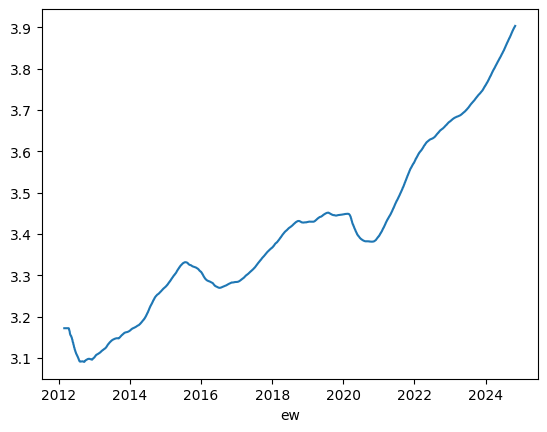

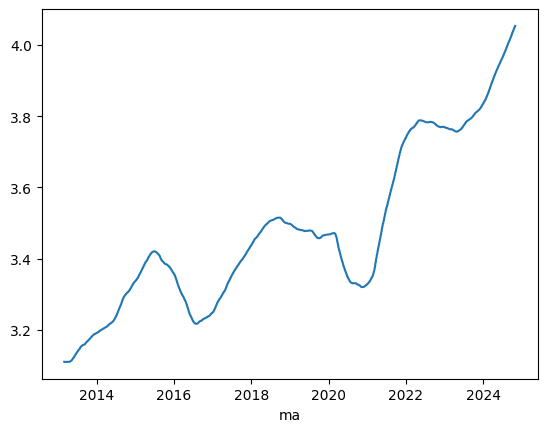

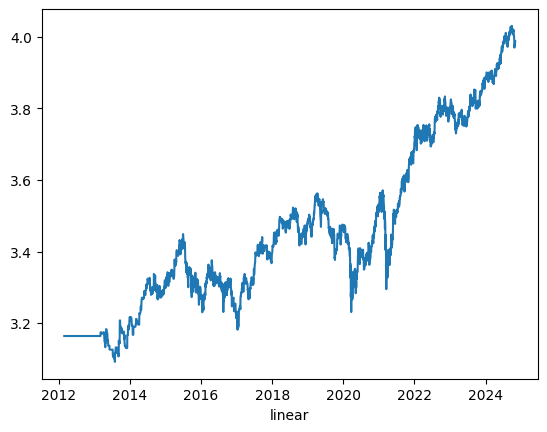

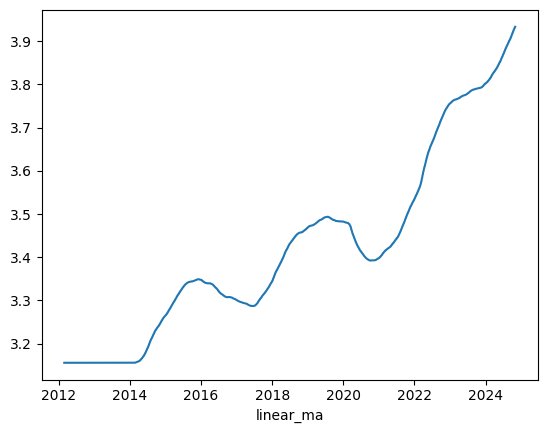

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params# = None, None

(20.550703872809642,
 {'time_param': 6,
  'method': 'ew',
  't': 0.861073346091497,
  'k': 4.310094606798808,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 2.5284842074938694
Round 1: 20.452567787764572
New best: 20.452567787764572
{'time_param': 6, 'method': 'ew', 't': 0.861073346091497, 'k': 4.310094606798808, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


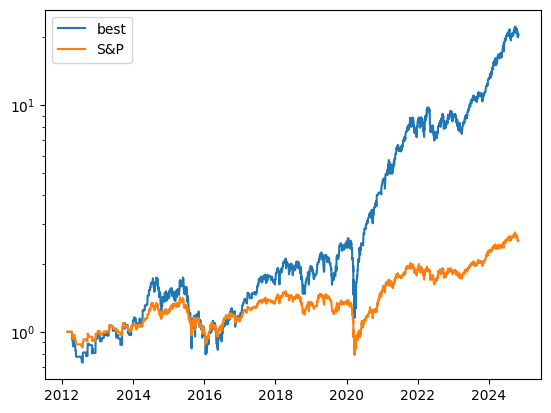

Round 2: nan
Round 3: 1.3190291364990407
Round 4: 5.504874978534095
Round 5: 10.705231253764058
Round 6: nan
Round 7: 9.352713102507261
Round 8: 3.335488784712669
Round 9: 2.6906349462149697
Round 10: nan
Round 11: nan
Round 12: 13.189080063099858
Round 13: nan
Round 14: nan
Round 15: 2.386127033879406
Round 16: nan
Round 17: nan
Round 18: 1.4088850920621956
Round 19: 3.578725408898136
Round 20: 9.06821169929091
Round 21: 1.1117451120814592
Round 22: 11.436812486143324
Round 23: 4.236861425743061
Round 24: 4.206550488060374
Round 25: nan
Round 26: 1.4402068302483804
Round 27: nan
Round 28: 2.778433507308577
Round 29: nan
Round 30: 5.771342047405898
Round 31: nan
Round 32: 9.792014185483671
Round 33: 13.461477709967161
Round 34: 3.9964827324806347
Round 35: nan
Round 36: nan
Round 37: 1.2947391263334171
Round 38: 13.167721067468326
Round 39: nan
Round 40: nan
Round 41: 7.111506358969658
Round 42: 10.986722378713038
Round 43: 10.500230310983895
Round 44: nan
Round 45: 2.5500085511362682


In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 2.5284842074938694
Round 1: 16.010718580715476
Round 2: 10.114412291527648
Round 3: 19.967905663113353
Round 4: 20.71956223380638
New best: 20.71956223380638
{'time_param': 5, 'method': 'ew', 't': 0.8696603583140355, 'k': 4.448859081267442, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


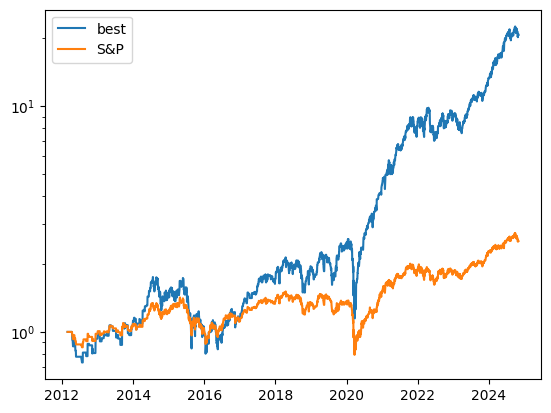

Round 5: 14.205021033161238
Round 6: 14.209364741480519
Round 7: 14.212367939148654
Round 8: 14.207144036756663
Round 9: 20.382981823040836
Round 10: 14.209373948629908

Factor: 1.03125
Do nothing res: 2.5284842074938694
Round 1: 14.209194577543785
Round 2: 8.324312076914538
Round 3: 20.62733238799776
Round 4: 19.367204157455333
Round 5: 13.944950267976928
Round 6: 20.66526135421185
Round 7: 5.93650343250422
Round 8: 14.208754522456793
Round 9: 14.21001149685907
Round 10: 4.276055952284997

Factor: 1.015625
Do nothing res: 2.5284842074938694
Round 1: 19.136948207171276
Round 2: 14.207616869878457
Round 3: 14.20722728103715
Round 4: 12.732894886381239
Round 5: 1.1327058682845514
Round 6: 14.301597669213225
Round 7: 11.568367286534324
Round 8: 20.926791091156783
New best: 20.926791091156783
{'time_param': 5, 'method': 'ew', 't': 0.9726481895944626, 'k': 4.453396232686577, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


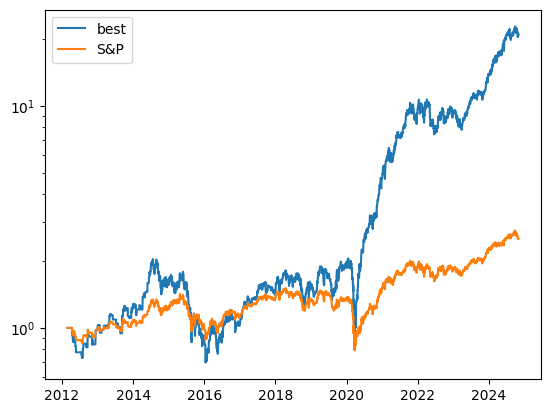

Round 9: 11.467130492573718
Round 10: 10.600194242301715

Factor: 1.0078125
Do nothing res: 2.5284842074938694
Round 1: 14.208634112991838
Round 2: 14.208038381929024
Round 3: 14.20850065070897
Round 4: 19.707619413473015
Round 5: 14.208369621563833
Round 6: 19.6739876236989
Round 7: 12.167714686538163
Round 8: 14.208013595824065
Round 9: 9.394647600722651
Round 10: 14.207727504564062



In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
# Force set:
#best_out = 33.55436395490332
#params_out = {'time_param': 153, 'method': 'ew', 't': 0.9977578507998721, 'k': 0.1502092583872895, 'as_q': True, 'transform_f': 'bounded_sigmoid'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

1.0

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.1774294670846395

In [24]:
params_out

{'time_param': 5,
 'method': 'ew',
 't': 0.9726481895944626,
 'k': 4.453396232686577,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


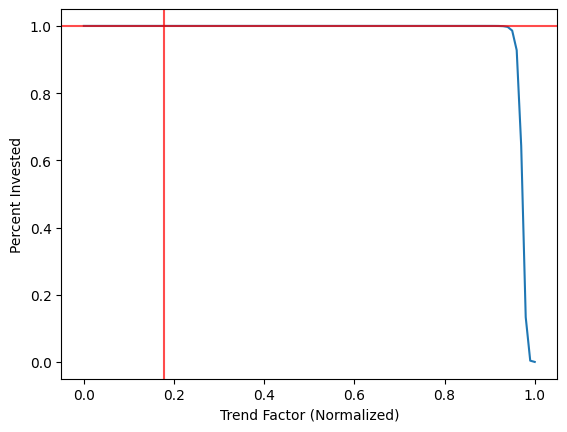

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

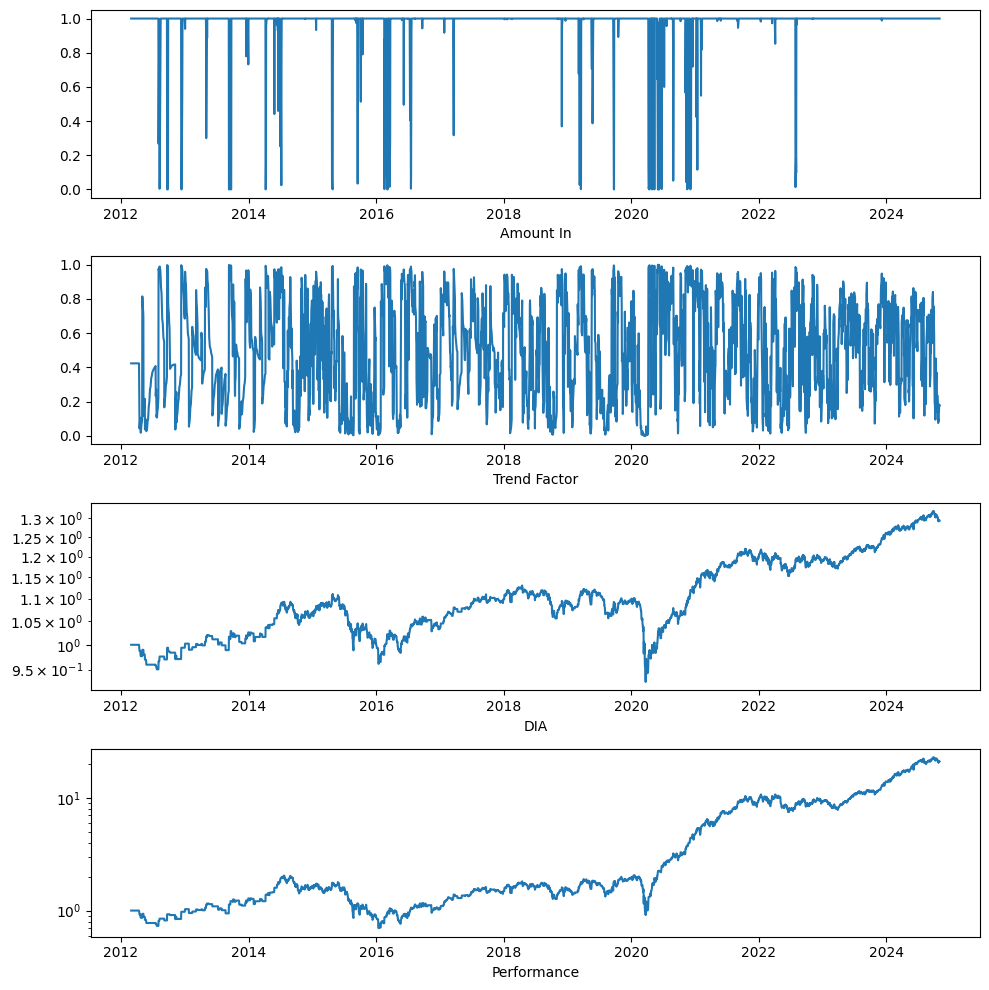

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('DIA')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

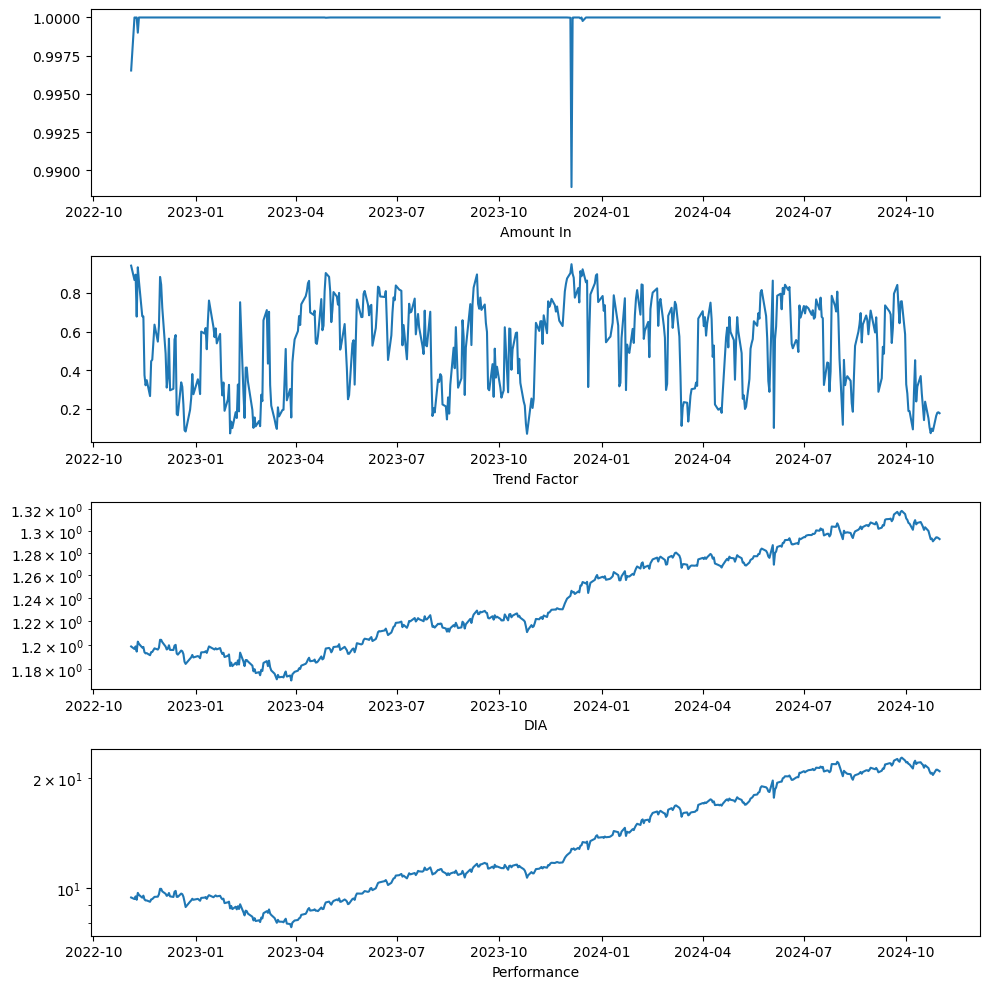

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(23.84827995300293, 12.764, 60.29999923706055)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.26902712645621607

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['nfty'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1202668911854718, 1.0], 'nas': [1.2412840054115306, 1.0], 'rus': [1.2929743800077413, 1.0], 'jpxn': [1.0743576183982226, 0.9816], 'ktec': [1.671831230298496, 0.0], 'emb': [1.0761592888276668, 1.0], 'gdx': [1.3585319518059944, 0.0056], 'dia': [1.2163458088040435, 1.0], 'nfty': [1.269027126456216, 1.0]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(20.926791091156783,
 {'time_param': 5,
  'method': 'ew',
  't': 0.9726481895944626,
  'k': 4.453396232686577,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})